In [1]:
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import vtk as vtk

In [2]:
%matplotlib widget

ModuleNotFoundError: No module named 'ipympl'

# Try to load case with `pyvista.read`

PyVista is smart enough to allow the load of an OpenFOAM case (`.foam` extension here)

In [3]:
# Import the OpenFOAM example case
case = pv.read('./case.foam')

In [4]:
case.keys()

['internalMesh']

In [5]:
mesh = case[0]

In [6]:
mesh

UnstructuredGrid (0x2a8bf688160)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	10

* It looks like the number of arrays is doubled here, there is 2 times the `Data Arrays` (don't know why)
* It looks like the case is loaded for `time=0`, I don't know how to change the time value.

Here is for example below the U field where it's 0 everywhere expect at the inlet which is the intial condtion at `time=0`.

In [7]:
mesh.plot(scalars='U',cpos='xy')

# Load the case with `vtkOpenFOAMReader`

In [8]:
reader = vtk.vtkOpenFOAMReader() 
# vtkOpenFOAMReader creates an multiblock dataset. 
# reads a controlDict file, mesh information, and time dependent data. 
# The controlDict file contains timestep information. 
# The polyMesh folders contain mesh information 
# The time folders contain transient data for the cells Each folder can contain any number of data files.
reader.SetFileName("case.foam")
# Indicates the file name
reader.UpdateInformation()
# Update the data if the file was modified 
time_array = reader.GetTimeValues()
# store the time values in an array
reader.SetTimeValue(time_array.GetRange()[1]) 
# Set read time to latest time step
reader.Update()
# updates
multi_block = pv.wrap(reader.GetOutput())
# includes vtk objects (output of reader) in multiblock
mesh = multi_block[0]

In [9]:
multi_block[0]

UnstructuredGrid (0x2a8bf688640)
  N Cells:	12225
  N Points:	25012
  X Bounds:	-2.060e-02, 2.900e-01
  Y Bounds:	-2.540e-02, 2.540e-02
  Z Bounds:	-5.000e-04, 5.000e-04
  N Arrays:	10

## Let's make a simple contour plot

Let's plot the $u_x$ component of the velocity field

In [10]:
mesh.plot(scalars='U',component=0, cpos='xy')

## Let's use a different and more useful API

### Show the mesh 

In [11]:
# Create a plotting object to display vtk meshes or numpy arrays
p1 = pv.Plotter()
# Show the mesh in wireframe style
p1.add_mesh(mesh,style="wireframe",color="w")
# View in the xy plane
p1.view_xy()
# Show the axes
p1.add_axes()
# Display the plotting window
p1.show()

### An example with a field contour

In [12]:
p2 = pv.Plotter()
p2.add_mesh(mesh,scalars='U')
p2.view_xy()
p2.add_axes()
p2.show()

### Another one with the mesh surimposed

In [15]:
p3 = pv.Plotter()
p3.add_mesh(mesh,scalars='U', show_edges=True)
p3.view_xy()
p3.add_axes()
p3.show()

### Plot the velocity field using glyphs

In [16]:
#U = mesh.cell_arrays['U']
# Perform the glyph
glyphs = mesh.glyph(orient='U',scale='U')
p4 = pv.Plotter()
p4.add_mesh(glyphs)
p4.view_xy()
p4.add_axes()
p4.show()

ValueError: Both ``scale`` and ``orient`` must use point data or cell data.

### Plot over line example

In [67]:
# Create the 2 points defining the line
a = [0, 0, 0]
b = [0, mesh.bounds[3], 0]

# Create a Line object
line = pv.Line(a, b)

In [68]:
mesh.bounds

[-0.020600000396370888,
 0.28999999165534973,
 -0.02539999969303608,
 0.02539999969303608,
 -0.0005000000237487257,
 0.0005000000237487257]

Let's show the line in the computational domain

In [66]:
p5 = pv.Plotter()
p5.add_mesh(mesh, style="wireframe", color='white')
# Show the line in red in the domain
p5.add_mesh(line, color="r", line_width=10)
p5.view_xy()
p5.add_axes()
p5.show()

Let's make a plot overline ...

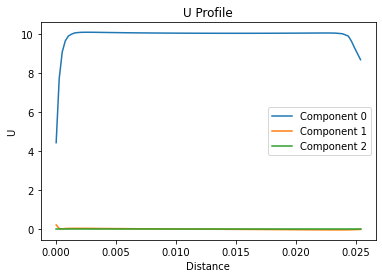

In [77]:
mesh.plot_over_line(a, b, resolution=100, scalars='U')

### How to access the vector components

List the available arrays 

In [50]:
mesh.cell_data

pyvista DataSetAttributes
Association     : CELL
Active Scalars  : U
Active Vectors  : U
Active Texture  : None
Active Normals  : None
Contains arrays :
    U                       float32  (12225, 3)           VECTORS
    epsilon                 float32  (12225,)
    k                       float32  (12225,)
    nut                     float32  (12225,)
    p                       float32  (12225,)

Let's put the velocity vector field in `U`

In [78]:
W = mesh.cell_arrays['U']
np.shape()

C:\ProgramData\Anaconda3\lib\site-packages\pyvista\core\dataset.py:1332: PyvistaDeprecationWarning: Use of `cell_arrays` is deprecated. Use `cell_data` instead.
  warnings.warn(


NameError: name 'U' is not defined

Put each component in numpy arrays

In [62]:
ux = U[:,0]
uy = U[:,1]
uz = U[:,2]

# One can also use
ux = mesh['U'][:,0]
uy = mesh['U'][:,1]
uz = mesh['U'][:,2]

In [63]:
mesh.cell_arrays["ux"] = ux
mesh.cell_arrays["uy"] = uy
mesh.cell_arrays["uz"] = uz

In [64]:
mesh.plot_over_line(a, b, resolution=50, scalars='ux')

TypeError: Point A must be a length three tuple of floats.

### Plot a scalar over a circular arc

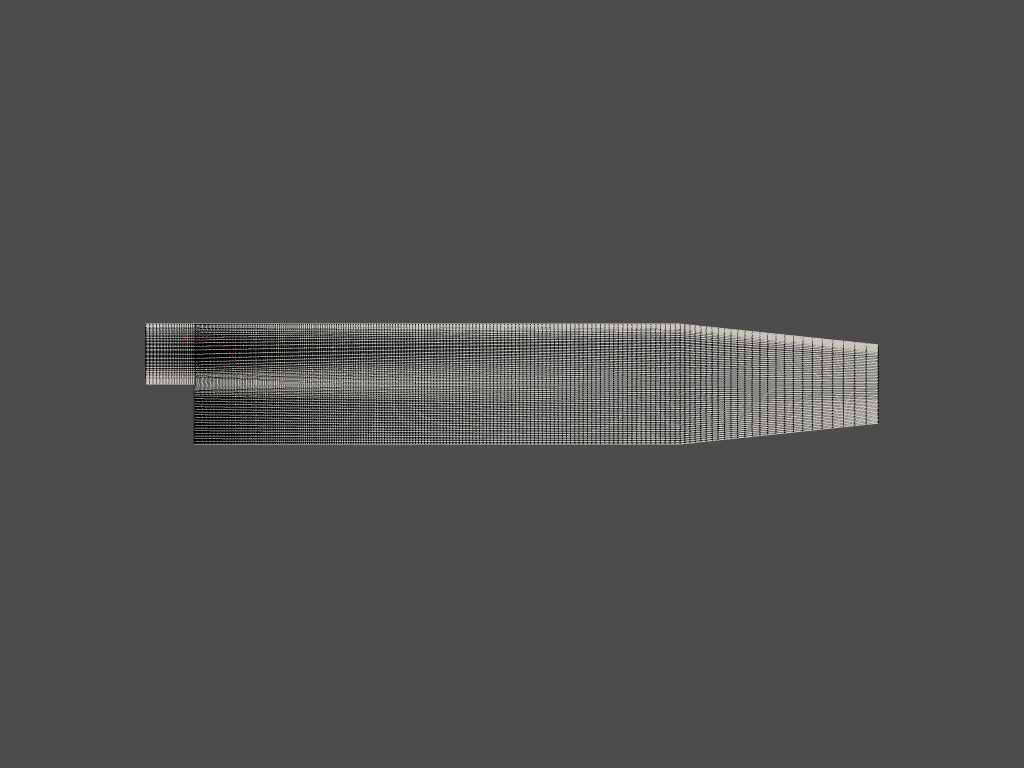

In [66]:
# Make two points at the bounds of the mesh and one at the center to
# construct a circular arc.
normal = [0, 0, 1]
polar = [0.02, 0, 0]
center = [0, 0, 0]
angle = 100.0

# Preview how this circular arc intersects this mesh
arc = pv.CircularArcFromNormal(center, 100, normal, polar, angle)

p = pv.Plotter()
p.add_mesh(mesh, style="wireframe", color="w")
p.add_mesh(arc, color="r")
a = arc.points[0]
b = arc.points[-1]
p.add_point_labels(
    [a, b], ["A", "B"], font_size=48, point_color="red", text_color="red"
)
p.view_xy()
p.show()


Let's see what's in the arc object.

In [67]:
arc

PolyData (0x1df1a276820)
  N Cells:	1
  N Points:	101
  X Bounds:	-3.473e-03, 2.000e-02
  Y Bounds:	0.000e+00, 2.000e-02
  Z Bounds:	0.000e+00, 0.000e+00
  N Arrays:	2

I don't know how to add another plot on the same figure, it's perhaps only possible to plot one scalar or one vector at a time with this API.

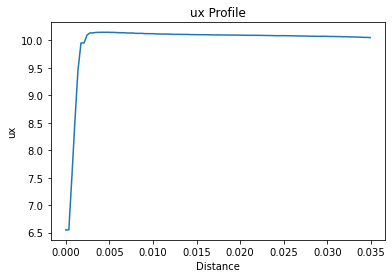

In [69]:
mesh.plot_over_circular_arc_normal(center, 100, normal, polar, angle,scalars='ux')
#mesh.plot_over_circular_arc_normal(center, 100, normal, polar, angle, scalars='uy')

So let's try another way and create the figure ourself (there may be better ways to do this by the way).

In [70]:
sampled = pv.DataSetFilters.sample_over_circular_arc_normal(mesh,
                                                         center,
                                                         100,
                                                         normal,
                                                         polar,
                                                         angle,
                                                         )


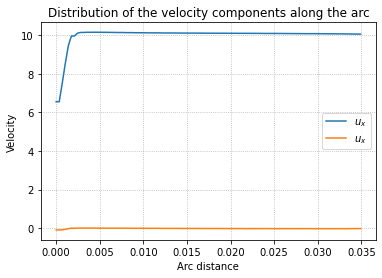

In [71]:
plt.figure()
plt.plot(sampled['Distance'],sampled['ux'],label='$u_x$')
plt.plot(sampled['Distance'],sampled['uy'],label='$u_x$')
plt.xlabel('Arc distance')
plt.ylabel('Velocity')
plt.title('Distribution of the velocity components along the arc')
plt.grid(linestyle='dotted')
plt.legend()
plt.show()